In [94]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,5) # to set specific params(length, width) for the data 

In [151]:
data = pd.read_csv('wwwusage.csv')
data.columns = ['Sales']
data.shape

(100, 1)

In [152]:
from datetime import datetime

datelist = pd.date_range(datetime.today(), periods=100).tolist()
data['Period']=datelist
data['Period']=data['Period'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [153]:
data['Period']=pd.to_datetime(data['Period'])
#data['Period']=data['Period'].dt.strftime('%Y/%m/%d')

In [154]:
data.set_index(['Period'], inplace=True) 

In [155]:
data.head()

,Sales
Period,
2022-01-04,88
2022-01-05,84
2022-01-06,85
2022-01-07,85
2022-01-08,84


In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2022-01-04 to 2022-04-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   100 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


### Visualization

<AxesSubplot:xlabel='Period'>

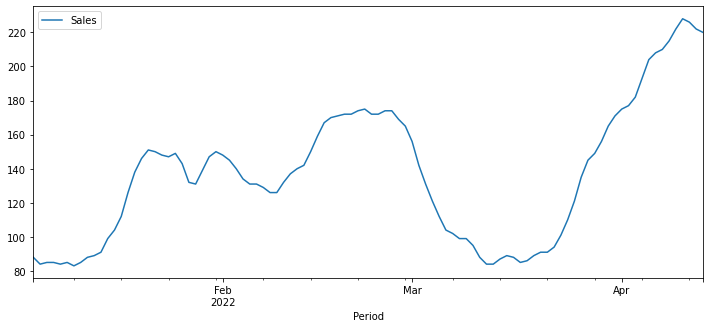

In [157]:
data.plot()

### Stationary Check

In [158]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean and Std Deviation')
    plt.grid()
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags U','Number of Observations used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

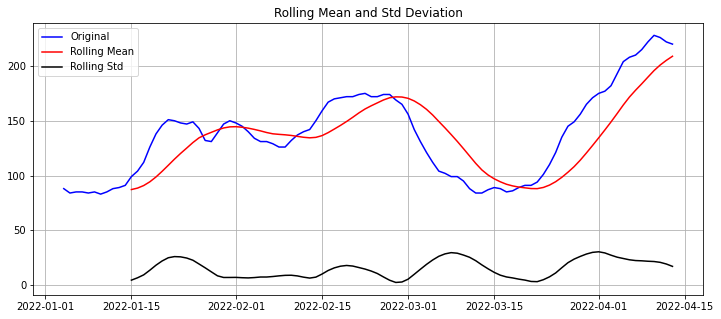

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags U                         3.000000
Number of Observations used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


In [159]:
test_stationarity(data['Sales'])

### Decomposition

#### Log

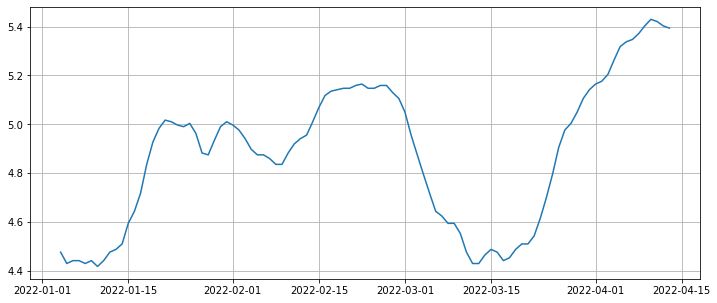

In [162]:
ts = data['Sales']
ts_log = np.log(ts)
plt.plot(ts_log)
plt.grid()

#### initalize moving standard deviation variable

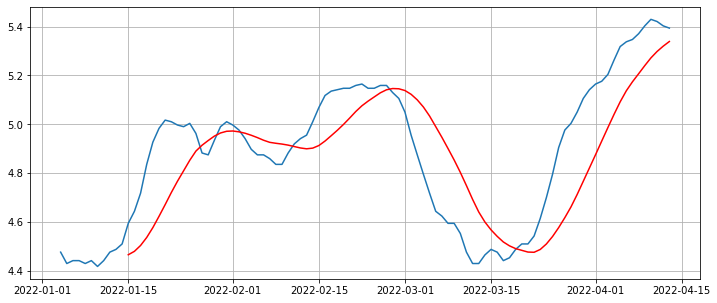

In [163]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()

plt.grid()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [164]:
ts_log_mv_diff = ts_log - movingAverage

ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Period
2022-01-15    0.128422
2022-01-16    0.163772
2022-01-17    0.213907
2022-01-18    0.298887
2022-01-19    0.349476
2022-01-20    0.359763
2022-01-21    0.345550
2022-01-22    0.289589
2022-01-23    0.229953
2022-01-24    0.180415
Name: Sales, dtype: float64

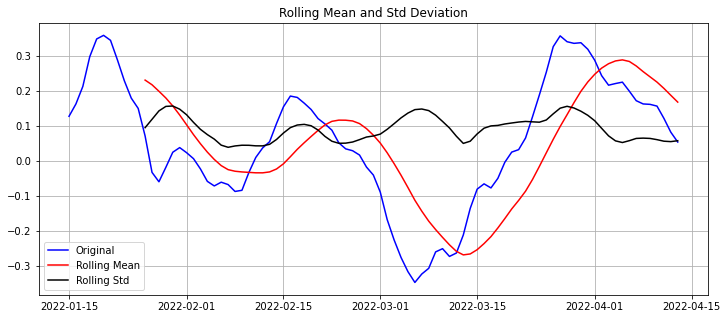

Results of Dickey-Fuller Test:
Test Statistic                 -3.137920
p-value                         0.023871
#Lags U                         3.000000
Number of Observations used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [165]:
test_stationarity(ts_log_mv_diff)

### Plotting ACF

In [167]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

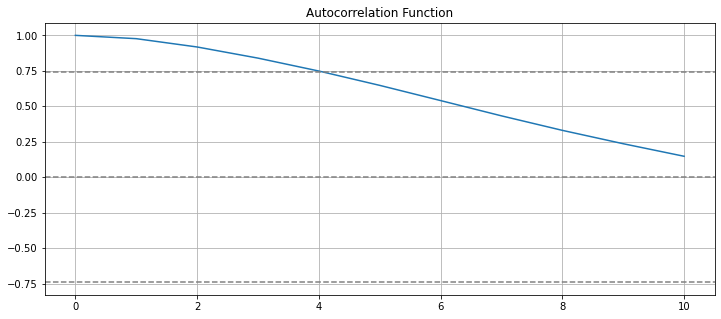

In [179]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.grid()
plt.show()

value of q = MA = 1 per the ACF curve

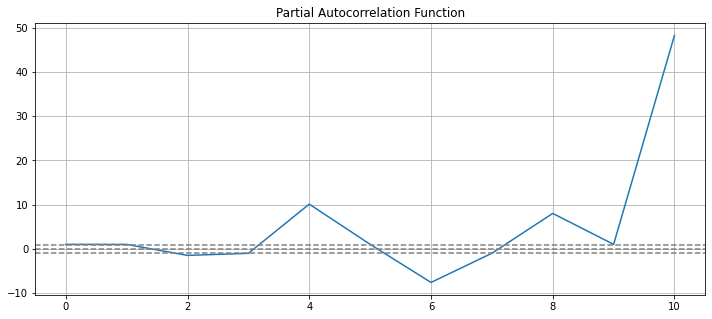

In [180]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.grid()
plt.show()

value of p = AR = 2 per the PACF curve

### ARIMA

In [169]:
from statsmodels.tsa.arima_model import ARIMA

Text(0.5, 1.0, 'RSS: nan')

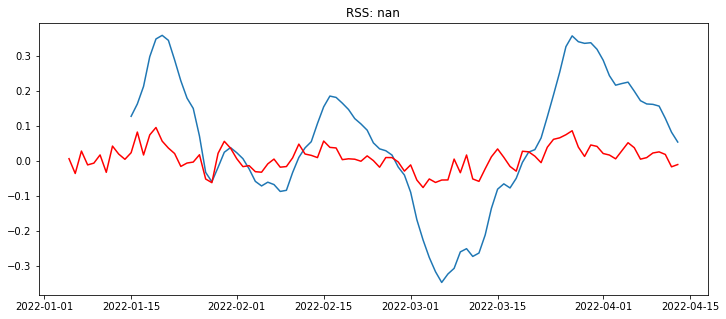

In [182]:
model = ARIMA(ts_log,order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues[1:]-ts_log_mv_diff)**2))

In [183]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Period
2022-01-05    0.007351
2022-01-06   -0.034933
2022-01-07    0.029121
2022-01-08   -0.010401
2022-01-09   -0.005383
dtype: float64

In [184]:
predictions_ARIMA_diff_cum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cum.head()

Period
2022-01-05    0.007351
2022-01-06   -0.027582
2022-01-07    0.001539
2022-01-08   -0.008862
2022-01-09   -0.014246
dtype: float64

In [185]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cum, fill_value=0)
predictions_ARIMA_log.head()

Period
2022-01-04    4.477337
2022-01-05    4.484688
2022-01-06    4.449755
2022-01-07    4.478876
2022-01-08    4.468474
dtype: float64

Text(0.5, 1.0, 'RMSE: 9.4249')

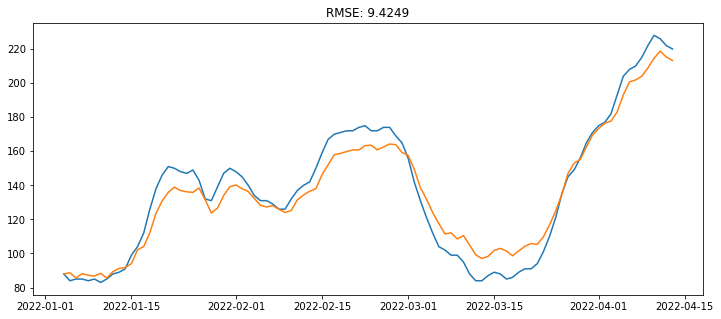

In [186]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

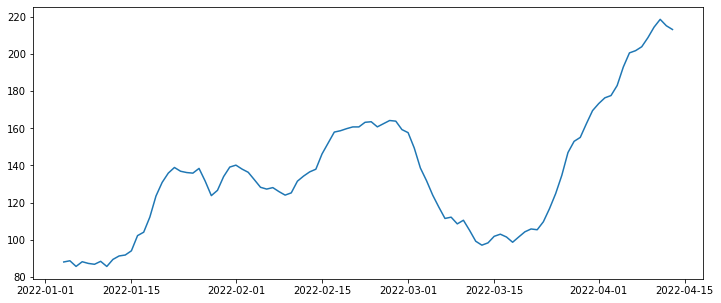

In [187]:
plt.plot(predictions_ARIMA)

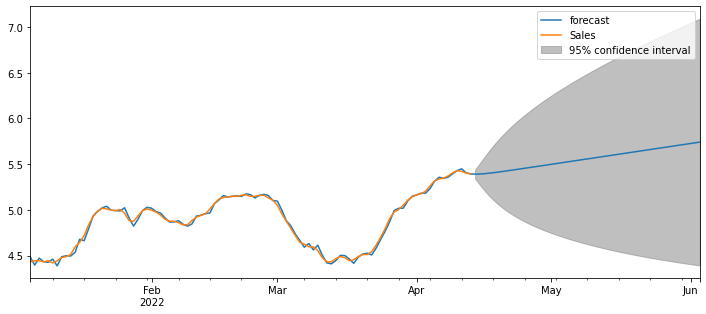

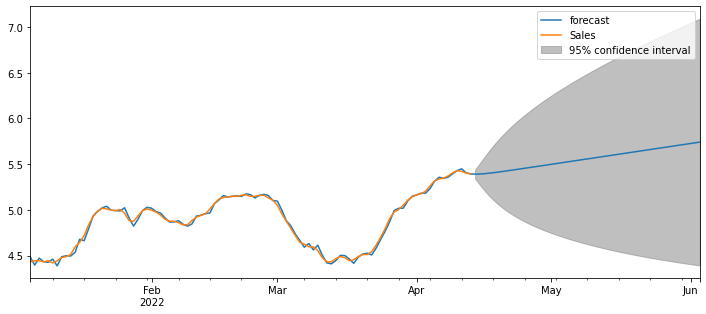

In [191]:
results_ARIMA.plot_predict(1,150)